## ML PROJECT 
---

Authors
 Andrea Scarpellini 
 Martina Scarpellini 


In [117]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('tyres_train.csv')
print(df.shape)

(3000, 16)


At first, we imported the dataset and printed it. 
It has 3000 rows and 16 columns.

In [118]:
df.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0


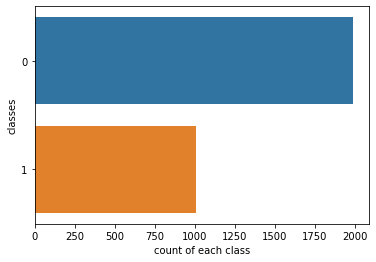

In [119]:
#Visualize Class Counts
sns.countplot(y=df.failure ,data=df) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

Then we watched if our data were imbalanced or not.
We noticed that they were imbalanced (the zeros were twice the one labelled observations).

- labelled observations are twice the one labelled observations

## MISSING VALUES

We wanted to look for missing values in our dataset.
We noticed that the coloumn 'diameter' was the only one with at least one missing value
(because it was the only one that gave 'true' as output).

In [293]:
#in which column of our dataset is there at least a missing values?
df.isna().any()

vulc               False
perc_nat_rubber    False
wiring_strength    False
weather            False
perc_imp           False
temperature        False
tread_type         False
tyre_season        False
elevation          False
month              False
tread_depth        False
tyre_quality       False
perc_exp_comp      False
diameter            True
add_layers         False
failure            False
dtype: bool

We searched the percentage of Nan values in the diameter.
We found that it was more than 70%.
We decided to omit the diameter attribute from our analysis.

In [294]:
#percentage of NaN values in "diameter"
a=df['diameter'].isna().sum();
print("NaN value in diameter:",a)
print("Perc of NaN:", a/len(df)*100,"%")


NaN value in diameter: 2110
Perc of NaN: 70.33333333333334 %


So we can omit the diameter attribute from the analysis

We listed all the attributes:
Attributes: 
- vulc            Numerical 
- perc_nat_rubber Numerical
- weather         Numerical
- perc_imp        Numerical
- temperature     Numerical 
- elevation       Numerical
- perc_exp_comp   Numerical
- diameter        Numerical
- tread_type      Categorical 
- tyre_season     Categorical 
- month           Categorical 
- tread_depth     Categorical 
- wiring_strenght Categorical
- tyre_quality    Categorical 
- add_layers      Categorical


Categorical attributes assume a finite number of distinct values, in most cases limited to less than a hundred, representing a qualitative property of
an entity to which they refer.
Numerical attributes assume a finite or infinite number of values and lend themselves to subtraction or division operations.

We identified the datatype of our data.
Some of the data are integers and some others are float. 

In [122]:
#come trattiamo le variabili categoriche 
print(df.dtypes)

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object


We have 7 categorical variables and 7 numerical.
We don't consider the 'diameter' because is full of Nan values. 

In [295]:
#non considero la colonna dei diametri perchè ci sono un sacco di nan e i valori non sono facili da predire 
cat=df[["tyre_season","month",          "tread_depth","wiring_strength","tyre_quality","tread_type","add_layers" ]]
num=df[["vulc",       "perc_nat_rubber","weather",    "perc_imp",       "temperature", "elevation", "perc_exp_comp"]]

print(cat.shape)
print(num.shape)

(3000, 7)
(3000, 7)


# CATEGORICAL DATA

In [296]:
cat.head()

,tyre_season,month,tread_depth,wiring_strength,tyre_quality,tread_type,add_layers
0,1,8,0,1,1,0,1
1,0,11,1,1,0,2,1
2,0,0,1,1,0,0,1
3,0,7,3,1,1,1,1
4,1,2,2,2,0,0,1


In [297]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


We plot the histograms of the seven categorical variables.

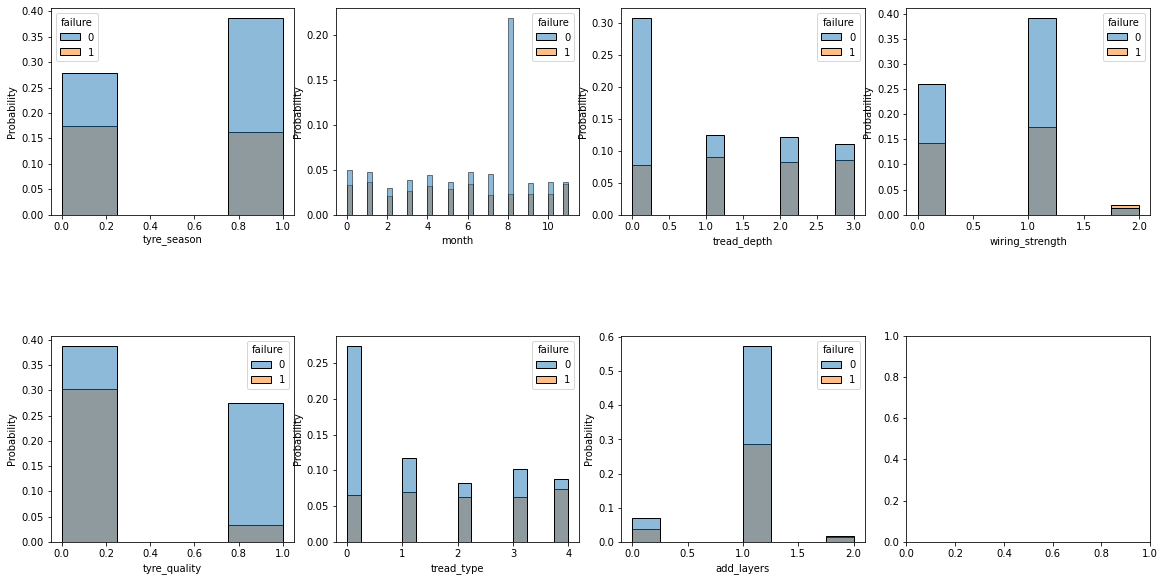

In [298]:
cat_plot=df[["tyre_season","month","tread_depth","wiring_strength","tyre_quality","tread_type","add_layers","failure"]]
fig, axes = plt.subplots(2, 4,figsize=[16,8])
axes = axes.flatten()
fig.tight_layout(h_pad=10)
i=0
for x in cat.columns:
    sns.histplot(data=cat_plot, x=x, hue="failure",stat ='probability' , ax=axes[i], binwidth=1/4 ,bins=len(set(cat_plot[x])))
    i=i+1
plt.show()

We can observe a peak of 0 labeled observations in correspondence of "month" = 8.This could be a noise-affected attribute.

So let's say how many 0 observation we have in september.

In [300]:
#try to correct month 8
print(((df['month']==8) & (df['failure']==0)).sum())
print(((df['month']==8) & (df['failure']==1)).sum())

#too many items to delete o change the labels --> so i wont consider the month column 

655
69


## ENTROPY  e  GINI 

We can measure homogeneity and heterogeneity of the data. In this way we can better understand how the failure distribution behave for each categorical attribute.

In [301]:
import collections
def CountFrequency(arr):
    return collections.Counter(arr)

def entropy(x):
    e=0
    for i in range(0,len(set(x))):
        e=e+CountFrequency(x)[i]/len(x) * np.log2( CountFrequency(x)[i]/len(x) )
    return -e 

#gini function 
def gini(x):
    tot=0
    for i in range(0,len(set(x))):
        tot=tot+ (CountFrequency(x)[i]/len(x))**2
    return 1-tot 


In [302]:
categories=['tyre_season','month','tread_depth','wiring_strength','tyre_quality','tread_type','add_layers'];

print("GINI --> 0.5 MAX ETEROGENETY\nGINI --> 0.0 MAX HOMOGENEITY**")
print("EI   --> 1   MAX ETEROGENETY\nEI   --> 0.0 MAX HOMOGENEITY**\n\n")
#gini index for categories:
for j in categories:
    print("-->",j,":\n")
    for i in set(df[j]):
        lis=(np.array([df[df[j]==i]['failure']])).astype(int)
        print(j ,"=",i) 
        print('Gini index:', round(gini(lis[0]),3), " || Entropy index:", round(entropy(lis[0]),3))
    
    print("##")
    print("\n")


GINI --> 0.5 MAX ETEROGENETY
GINI --> 0.0 MAX HOMOGENEITY**
EI   --> 1   MAX ETEROGENETY
EI   --> 0.0 MAX HOMOGENEITY**


--> tyre_season :

tyre_season = 0
Gini index: 0.474  || Entropy index: 0.962
tyre_season = 1
Gini index: 0.416  || Entropy index: 0.875
##


--> month :

month = 0
Gini index: 0.48  || Entropy index: 0.97
month = 1
Gini index: 0.491  || Entropy index: 0.987
month = 2
Gini index: 0.486  || Entropy index: 0.98
month = 3
Gini index: 0.482  || Entropy index: 0.973
month = 4
Gini index: 0.487  || Entropy index: 0.981
month = 5
Gini index: 0.492  || Entropy index: 0.988
month = 6
Gini index: 0.489  || Entropy index: 0.983
month = 7
Gini index: 0.442  || Entropy index: 0.915
month = 8
Gini index: 0.172  || Entropy index: 0.454
month = 9
Gini index: 0.476  || Entropy index: 0.965
month = 10
Gini index: 0.474  || Entropy index: 0.962
month = 11
Gini index: 0.499  || Entropy index: 0.999
##


--> tread_depth :

tread_depth = 0
Gini index: 0.321  || Entropy index: 0.724
tread

### DUMMIES
To properly treat the categorical variables, we first need to define N-1 binary variables Dj1,Dj2....DjN-1, called dummies varibles.

In [299]:
#categorical variables have the "object" type
#Categorical variables must be changed in the pre-processing section
#since machine learning models require numeric input variables
cat = cat.astype(str)
cat.dtypes

tyre_season        object
month              object
tread_depth        object
wiring_strength    object
tyre_quality       object
tread_type         object
add_layers         object
dtype: object

In [303]:
selection_categorical=['tyre_season','tread_depth','wiring_strength','tyre_quality','tread_type','add_layers'];
dummies = pd.get_dummies(cat[selection_categorical]) 
dummies.tail()

,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,tread_depth_3,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
2996,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2997,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
2998,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
2999,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0


## NUMERICAL DATA

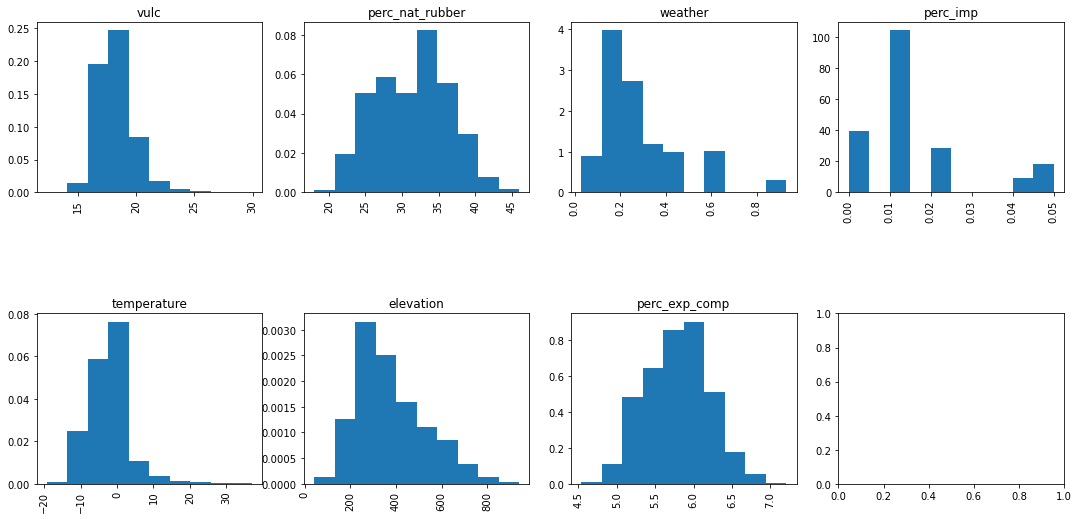

In [304]:
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in num.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist(num[x],density=True)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()

array([[<AxesSubplot:title={'center':'vulc'}>,
        <AxesSubplot:title={'center':'logvulc'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'logweather'}>,
        <AxesSubplot:title={'center':'perc_imp'}>],
       [<AxesSubplot:title={'center':'logpercimp'}>,
        <AxesSubplot:title={'center':'elevation'}>,
        <AxesSubplot:title={'center':'logelevation'}>,
        <AxesSubplot:title={'center':'logtemperature'}>,
        <AxesSubplot:title={'center':'temperature'}>]], dtype=object)

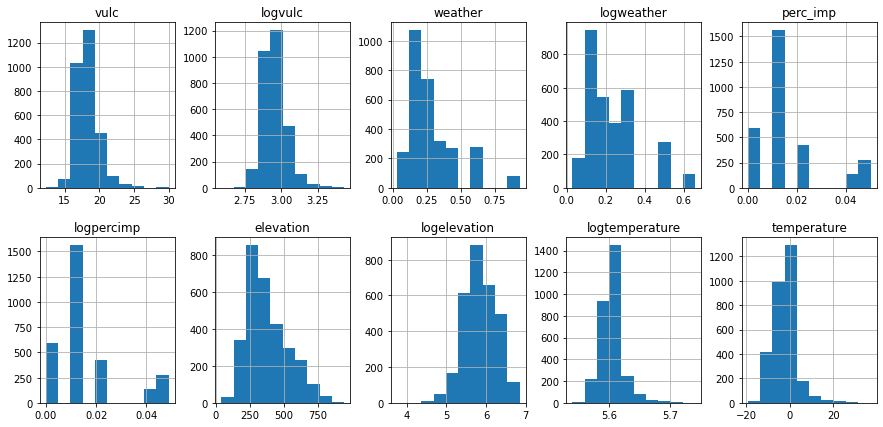

In [305]:
import math
pd.options.mode.chained_assignment = None # no warning on creating a new column

num['logvulc']=num['vulc'].apply(lambda x: math.log(x+1))
num['logweather']=num['weather'].apply(lambda x: math.log(x+1))
num['logpercimp']=num['perc_imp'].apply(lambda x: math.log(x+1))
num['logelevation']=num['elevation'].apply(lambda x: math.log(x+1))
num['logtemperature']=(num['temperature']+273.15).apply(lambda x: math.log(x+1))
num[['vulc','logvulc',
     'weather','logweather',
     'perc_imp','logpercimp',
     'elevation','logelevation',
     'logtemperature','temperature']].hist(layout=(2,5), figsize=(15,7))

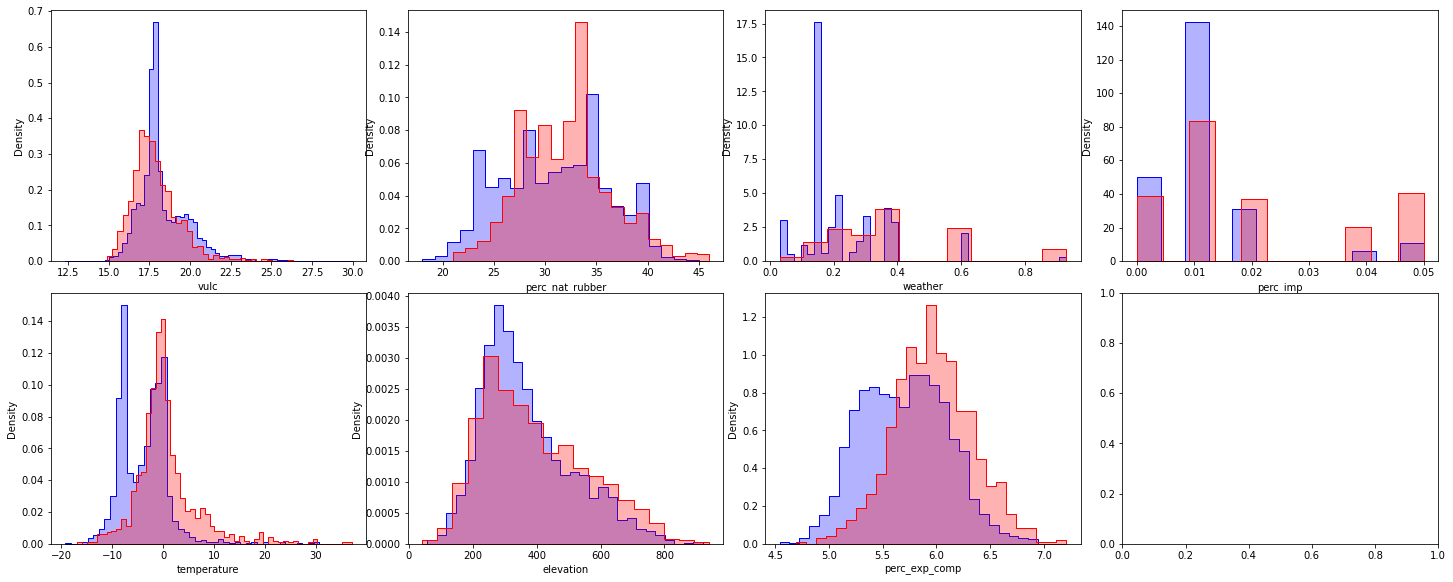

In [306]:
X0 = num[df['failure']==0]
X1 = num[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(cat.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

##provare ad applicare quache trasf

Since we do not exclude any numerical features except diameter and we do not apply any 
numerical transformation let's consider the columns of interest as follows:

In [308]:
#at the end let's take the column of interest 
num=df[["vulc", "perc_nat_rubber","weather","perc_imp","temperature","elevation","perc_exp_comp"]]


## ANALISI PCA 
The purpose of this method is to obtain a projective transformation that replaces a subset of the original numerical attributes with a lower number of new attributes obtained
as their linear combination, without this change causing a loss of information.

<AxesSubplot:>

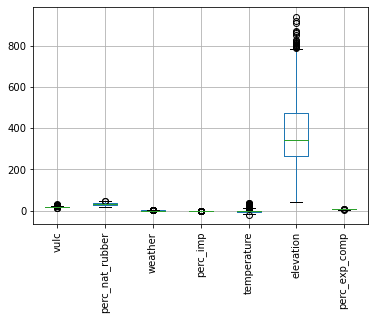

In [138]:
num.boxplot(rot=90)

#elevation has totally different numbers --> standardization 

to properly apply PCA analysis standardization is required 

In [139]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(num) # No target
scaled_num = pd.DataFrame(scaler.transform(num))
scaled_num.columns = num.columns
scaled_num.tail()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
2995,-0.231083,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809
2996,-0.698653,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070
2997,-1.269567,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937
2998,0.433093,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072
2999,1.315301,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200


In [1]:
scaled_num.boxplot(rot=90)
#ok! 

NameError: name 'scaled_num' is not defined

In [309]:
#PCA fit
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_num) 

PCA()

In [310]:
#let's use the pca to transform the dataset
num_pca = pd.DataFrame(pca.transform(scaled_num))
num_pca.columns =['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
num_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.039807,-1.005052,0.143276,0.280682,-0.055187,0.362670,0.070427
1,0.230444,1.339307,1.267905,-0.763265,0.159000,-0.653739,-0.277058
2,0.623754,0.939546,0.072528,-1.191816,0.466955,-0.734820,-0.208645
3,1.967707,1.162369,-1.581563,-0.294469,0.319924,-0.303452,0.923830
4,2.771142,0.328019,-2.985996,-0.799060,3.063998,3.395502,-0.162010
...,...,...,...,...,...,...,...
2995,0.625458,-0.250981,-0.783154,-0.636191,0.673647,1.360141,-0.495100
2996,-0.779224,-0.093864,-1.159095,-1.344233,0.107791,-0.019557,-0.391418
2997,-0.118266,-0.862350,-0.778459,-0.789547,-1.028185,0.076134,-0.574664
2998,-0.695504,1.737254,-0.289416,-0.992616,-0.390970,0.111279,0.471484


In [311]:
pd.DataFrame(pca.components_,index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'],columns=num.columns)

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
PC1,-0.080281,0.292608,0.509765,0.442437,0.469686,0.157051,0.455033
PC2,0.388180,0.472226,-0.373902,-0.496069,0.214217,0.262835,0.354203
PC3,0.796293,0.176996,0.232871,0.334312,-0.341043,0.047571,-0.223659
PC4,-0.104280,-0.256250,-0.006530,0.057527,-0.132234,0.945590,-0.092107
PC5,0.425614,-0.764839,-0.071712,0.003050,0.302535,-0.083554,0.360851
PC6,0.124018,0.013110,0.024990,-0.070775,0.705190,0.052928,-0.691896
PC7,-0.037241,0.096131,-0.735050,0.661871,0.104354,-0.008160,0.006628


In [312]:
pd.DataFrame(pca.explained_variance_).transpose()

,0,1,2,3,4,5,6
0,2.611119,1.17498,1.042926,0.946682,0.7149,0.332083,0.179644


          0         1        2         3         4         5         6
0  0.372893  0.167798  0.14894  0.135195  0.102095  0.047425  0.025655


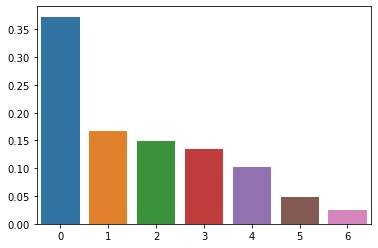

In [313]:
#VISUALIZE The percentage of variance explained by each of the selected components.
explained_var=pd.DataFrame(pca.explained_variance_ratio_).transpose()
print(explained_var)
ax = sns.barplot( data=explained_var)

In [314]:
cum_explained_var=np.cumsum(pca.explained_variance_ratio_)
cum_explained_var= pd.DataFrame(cum_explained_var).transpose()
cum_explained_var

,0,1,2,3,4,5,6
0,0.372893,0.540691,0.689631,0.824826,0.92692,0.974345,1.0


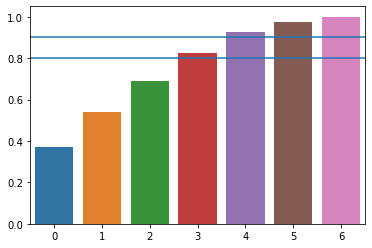

In [315]:
ax = sns.barplot(data=cum_explained_var)
ax.axhline(0.9)
ax.axhline(0.8)

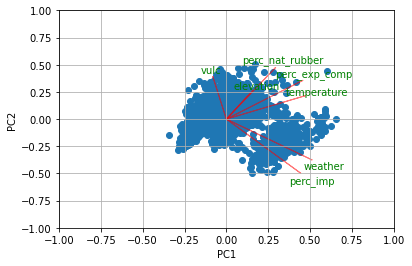

In [316]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(pca.transform(scaled_num)[:,0:2],np.transpose(pca.components_[0:2, :]), num.columns)
plt.show()



#perc_imp e wheater sono correlate? 

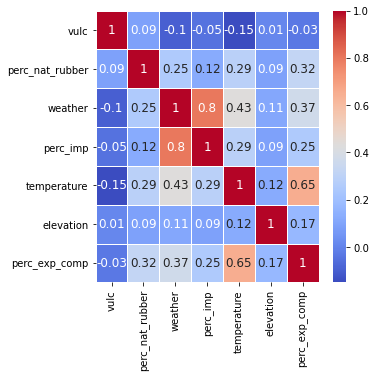

In [319]:
plt.figure(figsize = (5,5))
sns.heatmap(data=scaled_num.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

#perc_imp e  weather

We see that there is a numerical correlation between "weather" and "perc_imp"
but we can not rationally explain it.

### TRAIN AND TEST
As first part of the analysis we deal with not over-sampled data, so with an unbalanced dataset.

In [320]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


In [321]:
dummies.tail()

,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,tread_depth_3,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
2996,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2997,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
2998,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
2999,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0


### CREATION OF X AND Y 

In [466]:
X=pd.concat([num,dummies], axis = 1)
print(X.shape)
X.tail()

(3000, 26)


,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,17.818,29,0.39,0.01,7.28,287.5,5.68,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2996,17.076,30,0.22,0.00,-1.44,152.5,5.81,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2997,16.170,33,0.39,0.01,-3.44,235.0,5.57,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2998,18.872,37,0.03,0.00,-0.76,290.0,5.89,1,0,1,...,1,0,0,0,0,0,1,1,0,0
2999,20.272,33,0.06,0.00,2.80,405.0,6.00,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [467]:
y=df['failure']
print(len(y))

3000


### SPLIT DATA 

In [468]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.25,   
                                                    stratify=y,        #preserve target propotions (probviamo non stratificata)
                                                    random_state= 321) #fix random seed for replicability

print( X_train.shape, X_test.shape)

(2250, 26) (750, 26)


### SCALER
Only for the training set.

In [469]:
scaler = StandardScaler().fit(X_train[num.columns]) 
X_train[num.columns] = scaler.transform(X_train[num.columns])
#scaled_train_num.columns =num.columns

X_train.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
1431,2.773315,1.745609,0.044915,-0.316414,-0.252453,-0.446068,0.300608,1,0,0,...,1,0,0,0,0,0,1,0,1,0
2899,-1.063544,0.341956,-0.338296,-1.015071,-0.521255,-1.173543,-0.214430,0,1,1,...,1,0,0,0,1,0,0,0,0,1
2342,0.527967,-0.460131,1.851477,2.478214,0.518582,1.111388,0.349659,0,1,1,...,1,0,0,0,1,0,0,0,1,0
2926,-1.280222,0.141435,0.099659,-0.316414,0.964227,0.469888,0.717543,1,0,0,...,1,0,0,1,0,0,0,0,0,1
1050,-1.306832,1.545087,1.851477,2.478214,0.702499,1.666914,1.796670,1,0,0,...,1,0,0,0,0,1,0,0,1,0


In [470]:
#Now lets's apply the scaler to the test set 
X_test[num.columns] = scaler.transform(X_test[num.columns])
X_test.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
96,1.736806,-0.259609,-0.666762,-0.316414,-1.957220,-0.786659,-1.735019,1,0,1,...,0,1,1,0,0,0,0,1,0,0
1607,-0.912756,-0.660652,0.099659,-0.316414,0.065864,-1.157009,-0.435161,1,0,1,...,1,0,1,0,0,0,0,0,1,0
75,-0.212035,-1.061696,-0.666762,-0.316414,-0.775909,-0.545269,-0.827571,0,1,1,...,0,1,1,0,0,0,0,0,1,0
412,-0.201898,-0.660652,0.482869,0.382243,-0.358559,-0.079024,0.128928,1,0,0,...,1,0,0,0,0,0,1,0,1,0
337,-0.136007,-1.061696,-0.666762,-0.316414,-1.030563,-0.555189,-0.852096,0,1,1,...,0,1,1,0,0,0,0,0,1,0


In [471]:
#Save the scaler
import pickle
pickle.dump(scaler, open('scaler_NOT_OVERSAMPLED.pkl', 'wb'))

C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


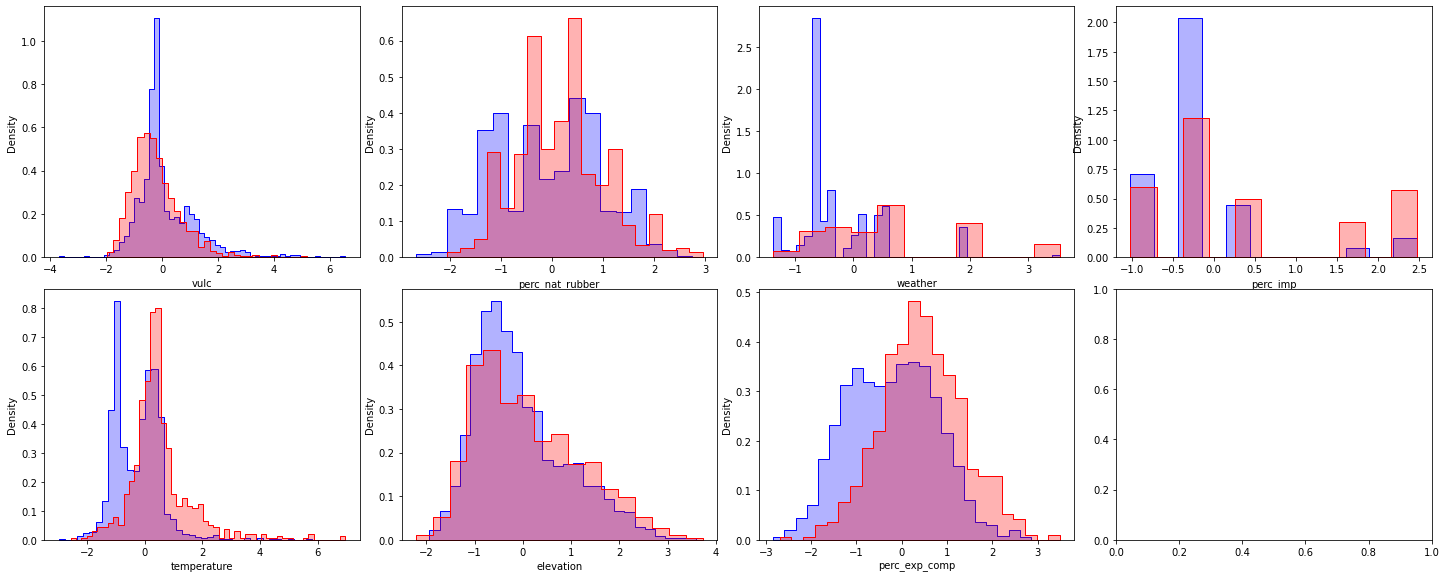

In [473]:
X0 = X_train[df['failure']==0]
X1 = X_train[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

### DATA DISCRETIZATION

In order to make learning algorithms more efficient we perfrom also a data discretization of some numerical attributes. 

The general purpose of data reduction methods is to obtain a decrease in the number of distinct values assumed by one or more attributes. Data discretization is the primary reduction method. On the one hand, it reduces continuous attributes to categorical attributes characterized by a limited number of distinct values. On the other hand, its aim is to significantly reduce the number of
distinct values assumed by the categorical attributes

In [475]:
from sklearn.preprocessing import KBinsDiscretizer

sel=['vulc','temperature','elevation','perc_nat_rubber','perc_exp_comp']
# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode="ordinal")
for  i in sel:
    X_train[i] = enc.fit_transform((np.array(X_train[i])).reshape(-1, 1))
    X_test[i]=   enc.fit_transform((np.array(X_test[i])).reshape(-1, 1))

C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


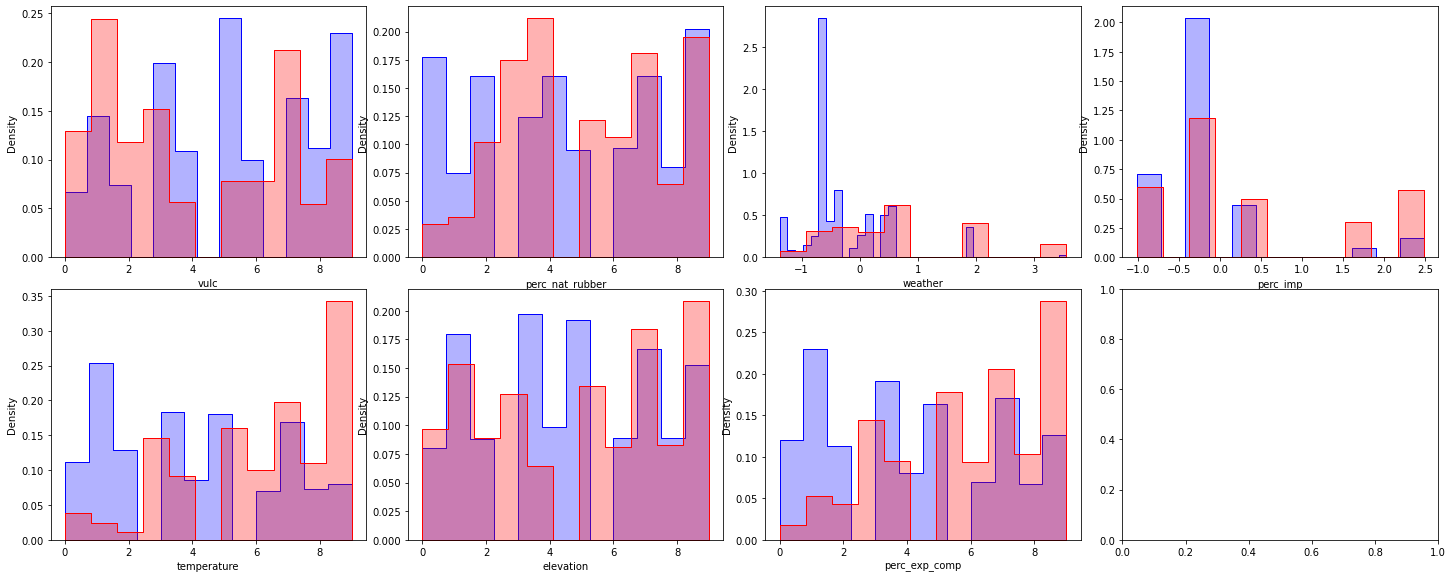

In [476]:
X0 = X_train[df['failure']==0]
X1 = X_train[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

print("Result of the data discretization")

## Models

In [477]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [478]:
#funzioni 


def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    print("\n")
    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) ))  
    print("\n")
    print(confusion_matrix(y_test, y_pred))
    return ( f1_score(y_train, y_pred_train),f1_score(y_test, y_pred) )

def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.3f' % auc)
    return (fpr, tpr ,auc)

## KNN 

In [480]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1,500,1)}
knn_f1_train,knn_f1_test = hyperp_search(classifier,parameters)

Fitting 3 folds for each of 499 candidates, totalling 1497 fits
f1_train: 0.536964 using {'n_neighbors': 11}


f1         train 0.638   test 0.532


[[438  60]
 [139 113]]


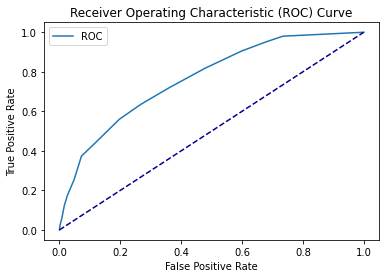

AUC: 0.763


In [430]:
model_knn = KNeighborsClassifier(n_neighbors=15)
fpr1,tpr1,AUC1=roc(model_knn,X_train,y_train,X_test,y_test)

## TREE 

In [482]:
#Tree
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth':          np.arange(5,50,5),
              'min_samples_split':  np.arange(15,50,1),
              'min_samples_leaf':   [2,4,6]}

tree_f1_train,tree_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 1890 candidates, totalling 5670 fits
f1_train: 0.572835 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 36}


f1         train 0.657   test 0.633


[[370 128]
 [ 76 176]]


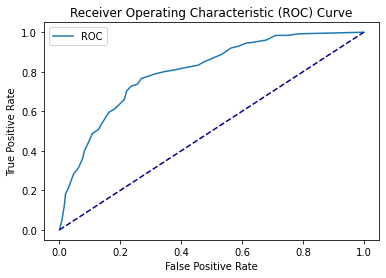

AUC: 0.803


In [432]:
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=39, min_samples_split=2)

fpr2,tpr2,AUC2=roc(model_tree,X_train,y_train,X_test,y_test)


## Naive Bayes 

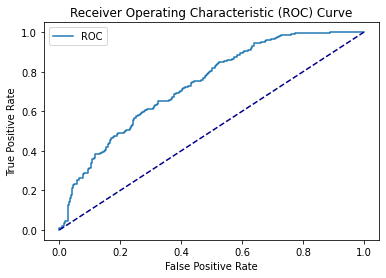

AUC: 0.733


In [433]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)



y_probs = model.predict_proba(X_test) 
fpr3,tpr3,AUC3=roc(model,X_train,y_train,X_test,y_test)

## Logistic

In [484]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":np.arange(1,10,1), "max_iter":[2000] }


logi_f1_train,logi_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
f1_train: 0.555263 using {'C': 2, 'max_iter': 2000}


f1         train 0.558   test 0.605


[[432  66]
 [114 138]]


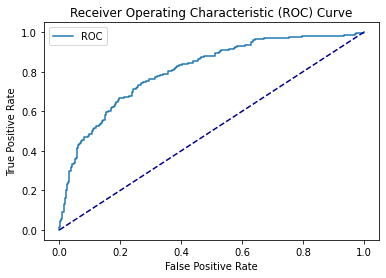

AUC: 0.807


In [435]:
model = LogisticRegression(C=9, max_iter=1000)

fpr4,tpr4,AUC4=roc(model,X_train,y_train,X_test,y_test)


## SUPPORT VECTOR MACHINE

In [485]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','sigmoid','rbf'],
              "C":[0.001,0.1,1,10],
              "degree":[2,3],
              "gamma":[1]}

SV_f1_train,SV_f1_test=hyperp_search(classifier,parameters)


#OVER-FITTING: using {'C': 50, 'kernel': 'rbf'}
# so we omit the 'rbf' among the possible parameters. 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_train: 0.552071 using {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


f1         train 0.559   test 0.610


[[447  51]
 [119 133]]


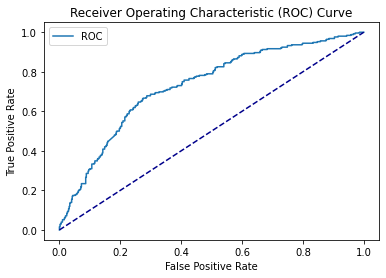

AUC: 0.729


In [437]:
model = SVC(C=0.1, kernel='sigmoid',probability=True)

fpr5,tpr5,AUC5=roc(model,X_train,y_train,X_test,y_test)

## NEURAL NETWORK

In [488]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"activation":[ 'relu'],       #'logistic'],
              "hidden_layer_sizes":[(9,6),(10, 5)], 
              "alpha": [0.001,0.01,1,10],
              "activation":['logistic', 'relu'],
              "learning_rate":['constant'], #'invscaling', 'adaptive'],
              "max_iter": [3000]}



NN_f1_train,NN_f1_test=hyperp_search(classifier,parameters)

#over fitting with: 'alpha': 0.1, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 2000
#over fitting 

Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_train: 0.566768 using {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant', 'max_iter': 3000}


f1         train 0.671   test 0.611


[[420  78]
 [107 145]]


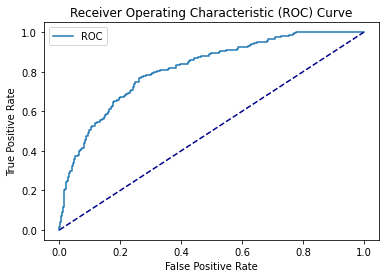

AUC: 0.815


In [439]:
model_MLP=MLPClassifier(activation='logistic',
                        alpha= 0.01,
                        hidden_layer_sizes= (10, 5),
                        learning_rate= 'constant',
                        max_iter= 2000)

fpr6,tpr6,AUC6=roc(model_MLP,X_train,y_train,X_test,y_test)

## RANDOM FOREST 

In [491]:
###### from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' :     [4,10,20],
              'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(5,20,1), 
              'min_samples_split': np.arange(15,50,5),
              'min_samples_leaf' : [2,4,6,8,10]
             };


RF_f1_train,RF_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 3150 candidates, totalling 9450 fits
f1_train: 0.571220 using {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 25, 'n_estimators': 4}


f1         train 0.662   test 0.545


[[427  71]
 [131 121]]


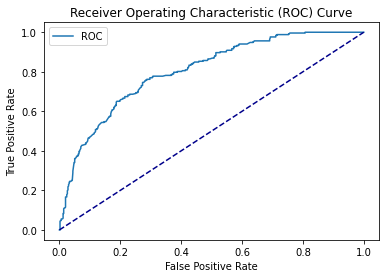

AUC: 0.804


In [261]:
rand_forest=RandomForestClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf= 4, min_samples_split= 9, n_estimators= 4)
fpr7,tpr7,AUC7=roc(rand_forest,X_train,y_train,X_test,y_test)

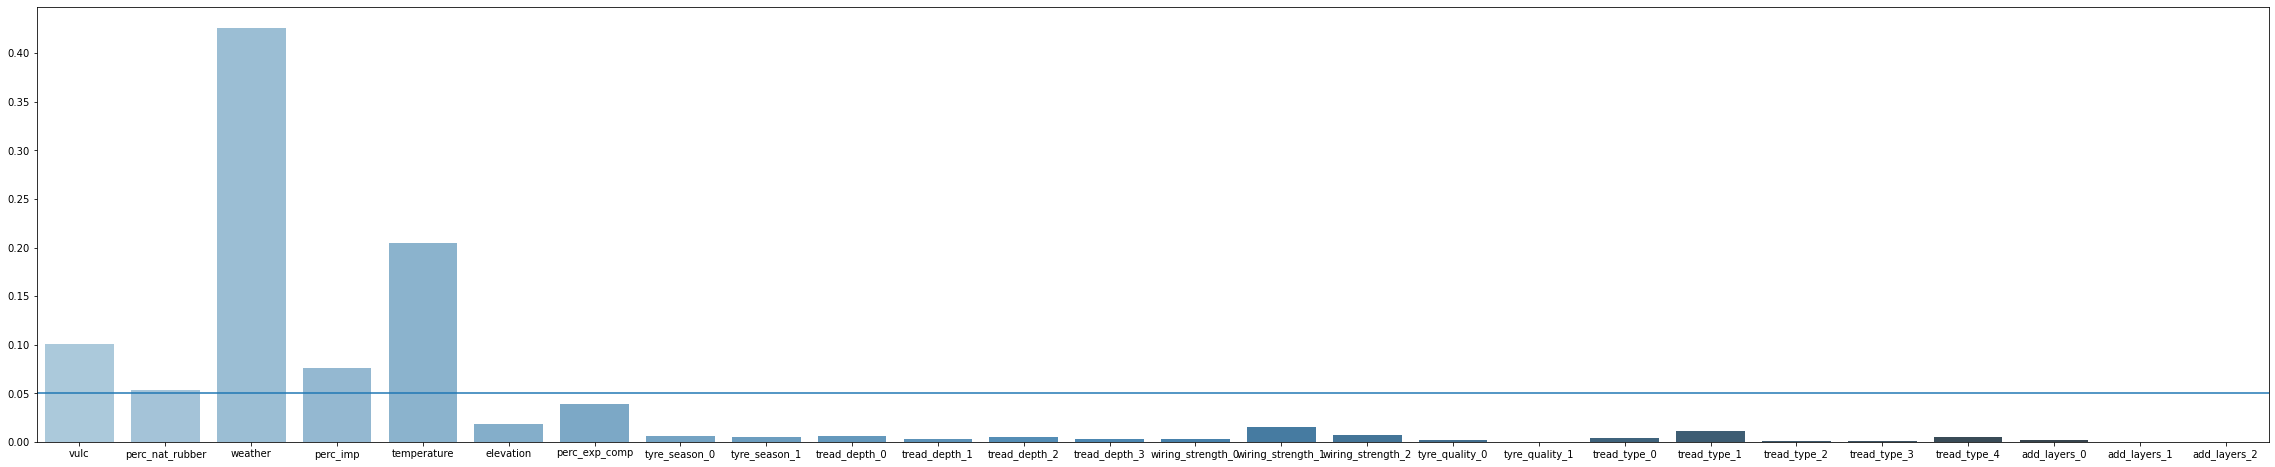

In [492]:
fig, axes = plt.subplots(figsize=[40,8])
graph=sns.barplot(x=X_train.columns, y=rand_forest.feature_importances_, palette="Blues_d")
graph.axhline(0.05)

## ADA BOOST 

In [503]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [6000],
              'learning_rate' : [0.01,0.1]}

ADAB_f1_train,ADAB_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
f1_train: 0.577231 using {'learning_rate': 0.01, 'n_estimators': 6000}


f1         train 0.601   test 0.579


[[421  77]
 [118 134]]


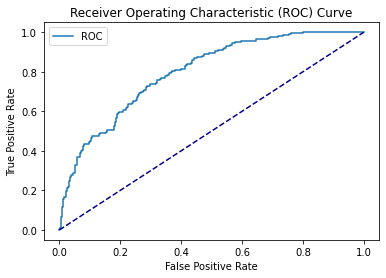

AUC: 0.797


In [264]:
AdaBoost_clf=AdaBoostClassifier(learning_rate= 0.01, n_estimators= 6000)
fpr8,tpr8,AUC8=roc(AdaBoost_clf,X_train,y_train,X_test,y_test)

## ROC CURVE COMPARISON 

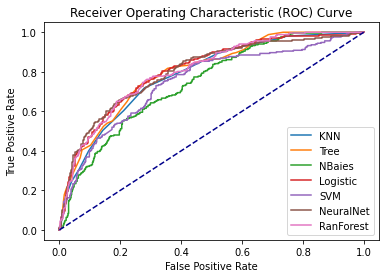

In [265]:
plt.plot(fpr1, tpr1, label= "KNN")
plt.plot(fpr2, tpr2, label= "Tree") 
plt.plot(fpr3, tpr3, label= "NBaies")   
plt.plot(fpr4, tpr4, label= "Logistic")
plt.plot(fpr5, tpr5, label= "SVM")
plt.plot(fpr6, tpr6, label= "NeuralNet")
plt.plot(fpr7, tpr7, label= "RanForest")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [266]:
F1_TRAIN=[knn_f1_train,tree_f1_train,logi_f1_train,SV_f1_train,NN_f1_train,RF_f1_train,ADAB_f1_train]
F1_TEST= [knn_f1_test, tree_f1_test, logi_f1_test, SV_f1_test, NN_f1_test, RF_f1_test,ADAB_f1_test]
data = {'Name': ['knn','tree','Logistic','SVM','Neural Network','Random Forest','ADABOOST']}
data['f1_train']=F1_TRAIN
data['f1_test']=F1_TEST

data=pd.DataFrame(data)

In [267]:
data

,Name,f1_train,f1_test
0,knn,0.596626,0.554054
1,tree,0.644674,0.619433
2,Logistic,0.547529,0.592105
3,SVM,0.543729,0.556660
4,Neural Network,0.610294,0.621277
5,Random Forest,0.549284,0.511509
6,ADABOOST,0.612335,0.553377


## OVER SAMPLING 

We oversample the train data and not the test data since if train data is unbalanced, our validation data will most likely show the same trait and be unbalanced.

In [504]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))

1494
756


In [505]:
 from sklearn.utils import resample

df_train=pd.concat([X_train,y_train], axis = 1)

#Down-sample Majority Class
#1) Separate majority and minority classes

df_majority = df_train[df_train.failure==0] 
df_minority = df_train[df_train.failure==1] 
#2) Oversample minority class
df_minority_oversampled = resample(df_minority, 
                                   replace=True,
                                   n_samples=1494,    # number of samples into the minority class 
                                   random_state=123)  # reproducible results
 
#3) Combine oversampled minority class with majority class
df_train_oversampled = pd.concat([df_minority_oversampled, df_majority])
 
#4) Display new class counts
df_train_oversampled.failure.value_counts()

0    1494
1    1494
Name: failure, dtype: int64

In [506]:
y_train=df_train_oversampled['failure']
X_train=df_train_oversampled.loc[:, df_train_oversampled.columns!='failure']

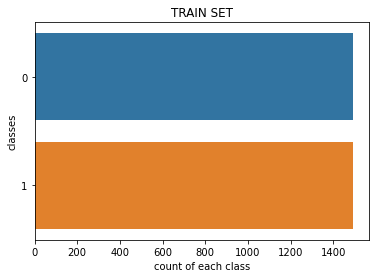

In [507]:
#Visualize Class Counts
sns.countplot(y=y_train[:]) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.title("TRAIN SET")
plt.show()

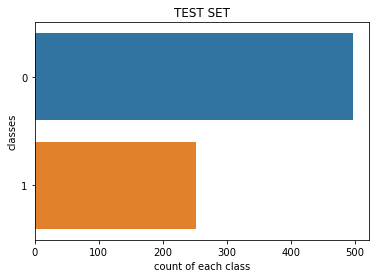

In [508]:
#Visualize Class Counts
sns.countplot(y=y_test[:]) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.title("TEST SET")
plt.show()

## KNN - OS

In [512]:
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(50,150,1)}
knn_f1_train,knn_f1_test = hyperp_search(classifier,parameters)

print("train")
print(knn_f1_train-knn_f1_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
f1_train: 0.723453 using {'n_neighbors': 89}


f1         train 0.725   test 0.591


[[342 156]
 [ 81 171]]
train
0.13406971735142026


## TREE - OS

In [516]:
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth':          np.arange(3,6,1),
              'min_samples_split':  np.arange(3,20,1),
              'min_samples_leaf':   [2,4,6]}

tree_f1_train,tree_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 306 candidates, totalling 918 fits
f1_train: 0.752037 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 3}


f1         train 0.757   test 0.617


[[286 212]
 [ 45 207]]


## LOGISTIC - OS

In [517]:

classifier = LogisticRegression()
parameters = {"C":[0.15,0.01,1], "max_iter":[1000] }

logi_f1_train,logi_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
f1_train: 0.726770 using {'C': 0.15, 'max_iter': 1000}


f1         train 0.734   test 0.645


[[353 145]
 [ 63 189]]


## SUPPORT VECTOR MACHINE 

In [518]:
classifier = SVC()
parameters = {"kernel":['linear','sigmoid','rbf'],
              "C":[0.1,0.3],
              "degree":[2,3,4],
              "gamma": [1]}

SV_f1_train,SV_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
f1_train: 0.732076 using {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


f1         train 0.745   test 0.635


[[346 152]
 [ 64 188]]


## NEURAL NETWORKS - OS

In [521]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(5, 2)], 
              "max_iter": [2000],
              "alpha": [0.1],
              "activation":['logistic', 'relu'],
              "learning_rate":['invscaling']}

NN_f1_train,NN_f1_test=hyperp_search(classifier,parameters)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
f1_train: 0.738931 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'invscaling', 'max_iter': 2000}


f1         train 0.754   test 0.619


[[333 165]
 [ 65 187]]


## RANDOM FOREST CLASSIFIER - OS

In [526]:
from sklearn.ensemble import RandomForestClassifier

classifier= RandomForestClassifier()
parameters = {'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(4,5,1),
              'min_samples_leaf' : np.arange(5,11,1),
              'min_samples_split': np.arange(7,9,1),
              'n_estimators' :     np.arange(6,9,1), 
             };

RF_f1_train,RF_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
f1_train: 0.757050 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 8}


f1         train 0.767   test 0.625


[[297 201]
 [ 46 206]]


## ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [6000],
              'learning_rate' : [0.001, 0.01]}

ADAB_f1_train,ADAB_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
f1_train: 0.732668 using {'learning_rate': 0.01, 'n_estimators': 6000}


In [291]:
F1_TRAIN=[knn_f1_train,tree_f1_train,logi_f1_train,SV_f1_train,NN_f1_train,RF_f1_train,ADAB_f1_train]
F1_TEST= [knn_f1_test, tree_f1_test, logi_f1_test, SV_f1_test, NN_f1_test, RF_f1_test,ADAB_f1_test]
data = {'Name': ['knn','tree','Logistic','SVM','Neural Network','Random Forest','ADABOOST']}
data['f1_train']=F1_TRAIN
data['f1_test']=F1_TEST

data=pd.DataFrame(data)

In [292]:
data

,Name,f1_train,f1_test
0,knn,0.756248,0.611570
1,tree,0.771816,0.615156
2,Logistic,0.736668,0.623064
3,SVM,0.747435,0.620926
4,Neural Network,0.772817,0.626087
5,Random Forest,0.777745,0.613924
6,ADABOOST,0.739008,0.616822
